# Load Dataset

In [1]:
import pandas as pd
df_2class = pd.read_csv('acetylcholinesterase_bioactivity_data_2class_pIC50.csv')
df_3class = pd.read_csv('acetylcholinesterase_bioactivity_data_3class_pIC50.csv')

In [2]:
columnNames = ["canonical_smiles", "pIC50"]
df_smiles = pd.DataFrame(data=df_3class, columns=columnNames)
df_smiles = df_smiles.drop_duplicates(subset=['canonical_smiles', 'pIC50'])
df_smiles = df_smiles.reset_index(drop=True)
df_smiles

,canonical_smiles,pIC50
0,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,6.124939
1,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,7.000000
2,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,4.301030
3,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,6.522879
4,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,6.096910
...,...,...
3570,O=C(NCCCCCCNc1c2c(nc3ccccc13)CCCC2)c1cc2ccccc2o1,6.372634
3571,O=C(NCCCCCCNc1c2c(nc3ccccc13)CCC2)c1cc2ccccc2o1,6.263603
3572,CCN(CCCCCCCCc1cccc(OC)c1)Cc1ccccc1OC,5.247952
3573,CC(C)=CC[C@H]1C[C@@]2(CC=C(C)C)C(=O)O[C@@](CC=...,5.017729


# Feature Extraction

## Generate Morgan Fingerprint with RDKit

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem

radius = 2
nBits = 1024
bit_list = []
morgan_fp = []
molecules = [Chem.MolFromSmiles(smiles) for smiles in df_smiles.canonical_smiles]
for mol in molecules:
    bit = {}
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol,useChirality=True, radius=radius, nBits = nBits, bitInfo=bit)
    morgan_fp.append(fingerprint)
    bit_list.append(bit)
morgan_binary = [list(fingerprint) for fingerprint in morgan_fp]

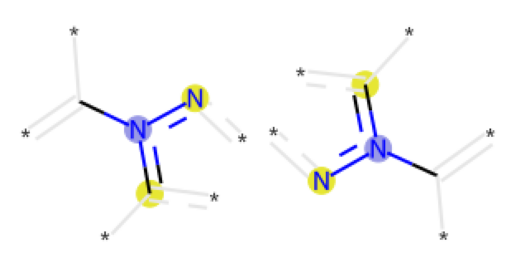

In [7]:
#try viisualize the substructure
from rdkit.Chem import Draw
from PIL import Image
import matplotlib.pyplot as plt
img1 = Draw.DrawMorganBit(molecules[6], 999, bit_list[6])
img2 = Draw.DrawMorganBit(molecules[8], 999, bit_list[8])

combined_img = Image.new('RGB', (img1.width + img2.width, max(img1.height, img2.height)))
combined_img.paste(img1, (0, 0))
combined_img.paste(img2, (img1.width, 0))

plt.imshow(combined_img)
plt.axis('off')
plt.show()

# Generate Fingerprints with PaDEL-Descriptor

In [8]:
# load generated fingerprints
padel_fp = pd.read_csv('padel_fp_all.csv')
len(padel_fp)

3575

# Split data for Cross Validation

In [9]:
from sklearn.model_selection import train_test_split
import numpy as np

# features = padel_fp
features = pd.DataFrame(morgan_binary, columns=range(1024))
target = df_smiles.pIC50
features_train, features_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=11)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
print('Size train:', np.shape(features_train))
print('Size test:', np.shape(features_test))

Size train: (2860, 1024)
Size test: (715, 1024)


In [10]:
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import pickle
import matplotlib.pyplot as plt

ss = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)
kfold = KFold(n_splits=10)
y_pred_list = []
importances_list = []

for idx, (train, val) in enumerate(ss.split(features)):
    # print(len(train), len(val))
    # print(len(features))
    X_train, X_val = features.iloc[train], features.iloc[val]
    y_train, y_val = target.iloc[train], target.iloc[val]
    
    
    model = RandomForestRegressor(n_estimators=100, random_state=41)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_list.append(y_pred)
    
    file=open(f"regression/model_{idx+1}.pkl", "wb")
    pickle.dump(model, file)
    file.close()

    mse = mean_squared_error(y_val, y_pred)
    mape = mean_absolute_percentage_error(y_val, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    
    print(f"MSE:{mse:.4f}, MAPE:{mape:.4f}, R2: {r2:.4f}, RMSE: {rmse:.4f}")
    
    importances = model.feature_importances_
    importances_list.append(importances)

MSE:0.6817, MAPE:0.1155, R2: 0.7080, RMSE: 0.8256
MSE:0.6873, MAPE:0.1119, R2: 0.7168, RMSE: 0.8291
MSE:0.5626, MAPE:0.1017, R2: 0.7638, RMSE: 0.7501
MSE:0.8561, MAPE:0.1257, R2: 0.6902, RMSE: 0.9253
MSE:0.5463, MAPE:0.1003, R2: 0.7688, RMSE: 0.7391
MSE:0.6364, MAPE:0.1124, R2: 0.7493, RMSE: 0.7977
MSE:0.6253, MAPE:0.1092, R2: 0.7624, RMSE: 0.7907
MSE:0.5258, MAPE:0.1020, R2: 0.8030, RMSE: 0.7251
MSE:0.6911, MAPE:0.1121, R2: 0.7023, RMSE: 0.8313
MSE:0.7986, MAPE:0.1191, R2: 0.6772, RMSE: 0.8937


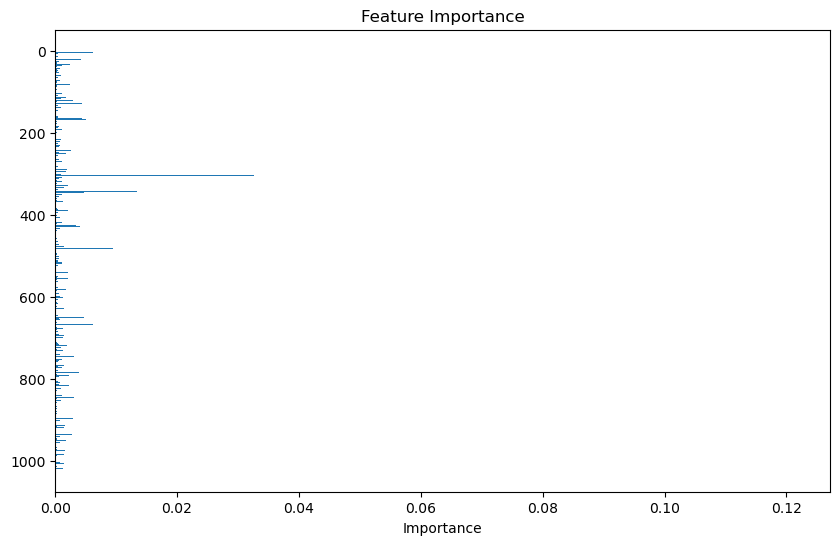

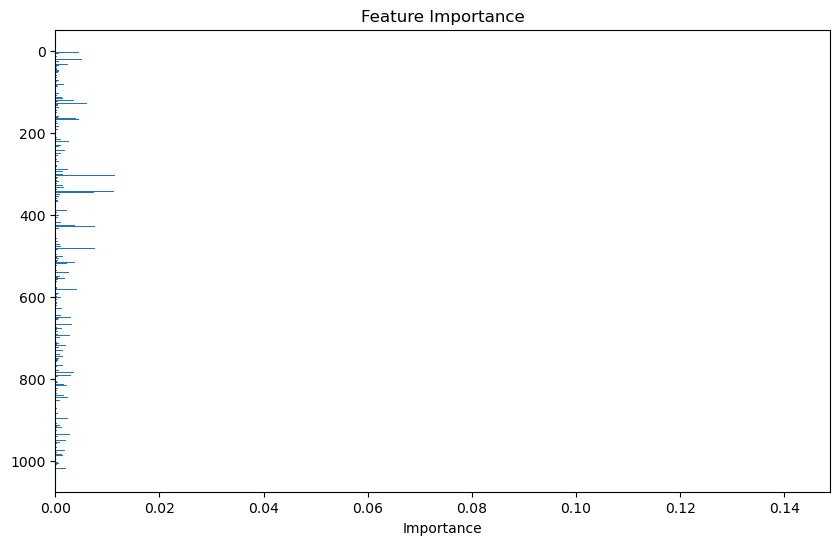

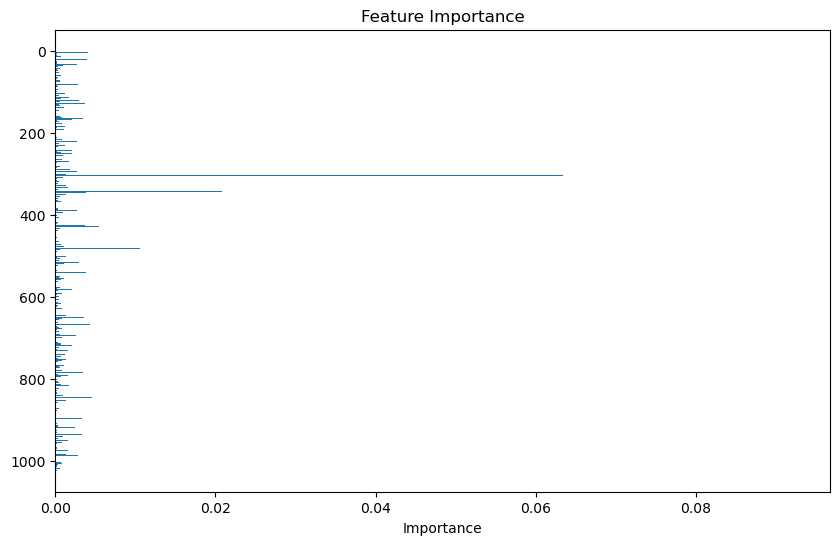

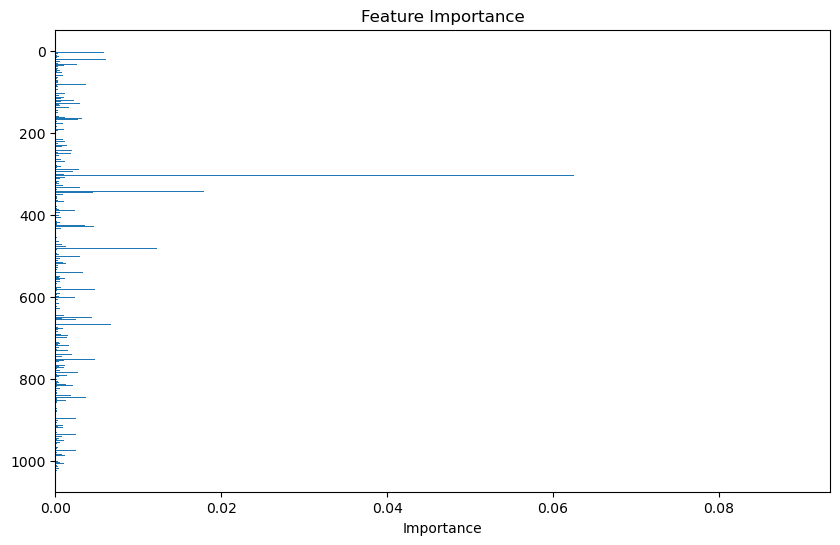

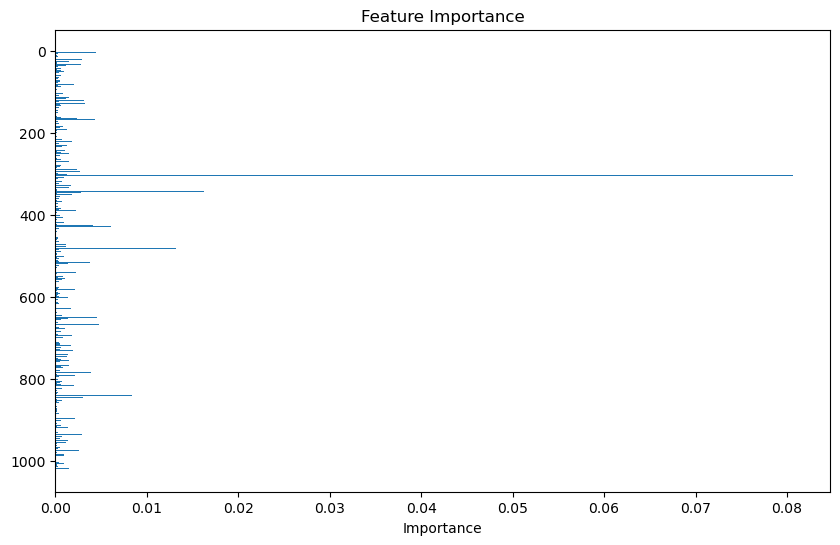

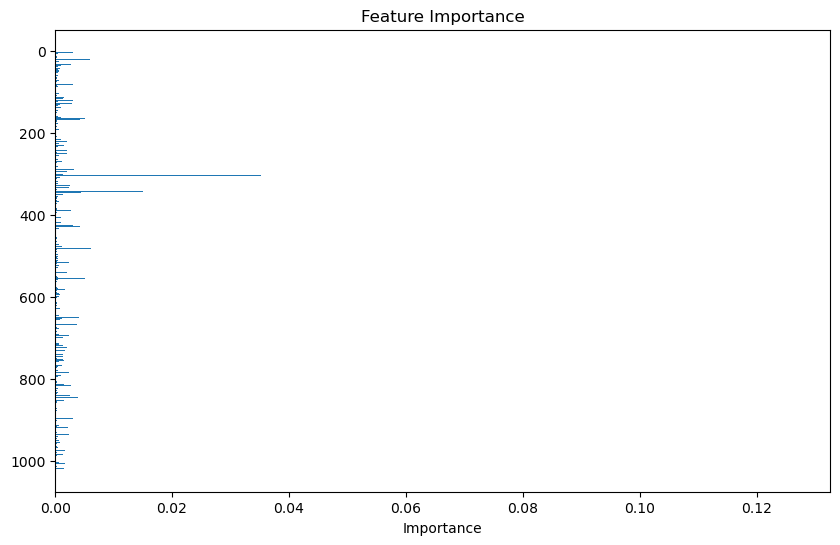

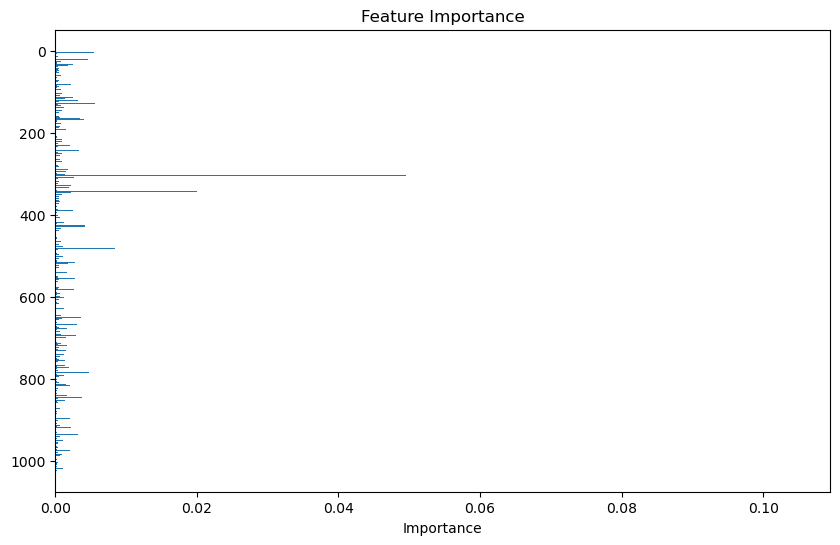

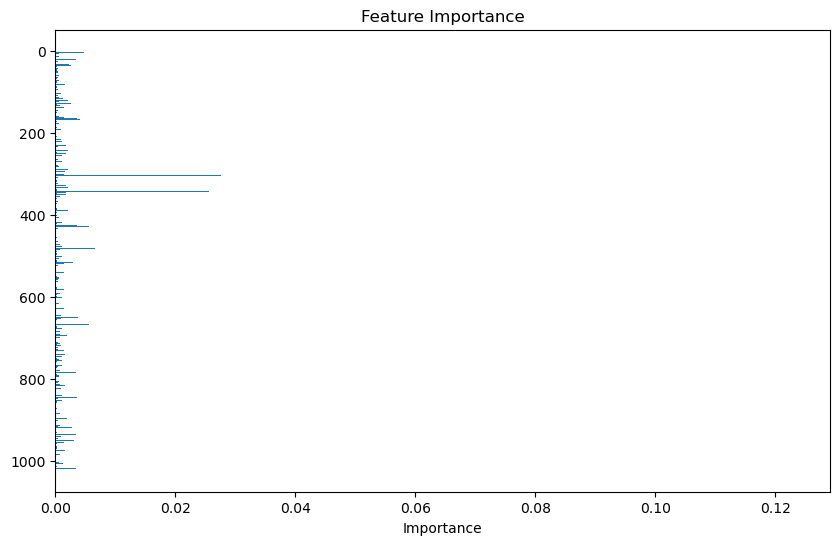

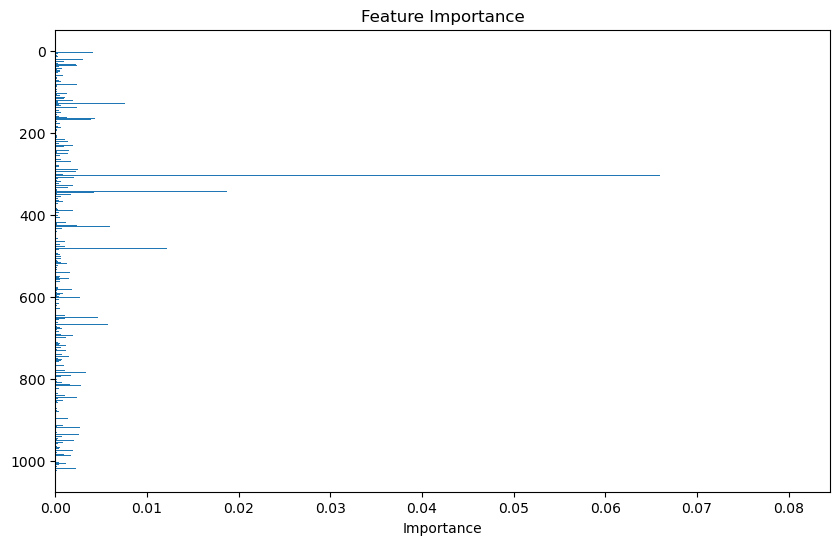

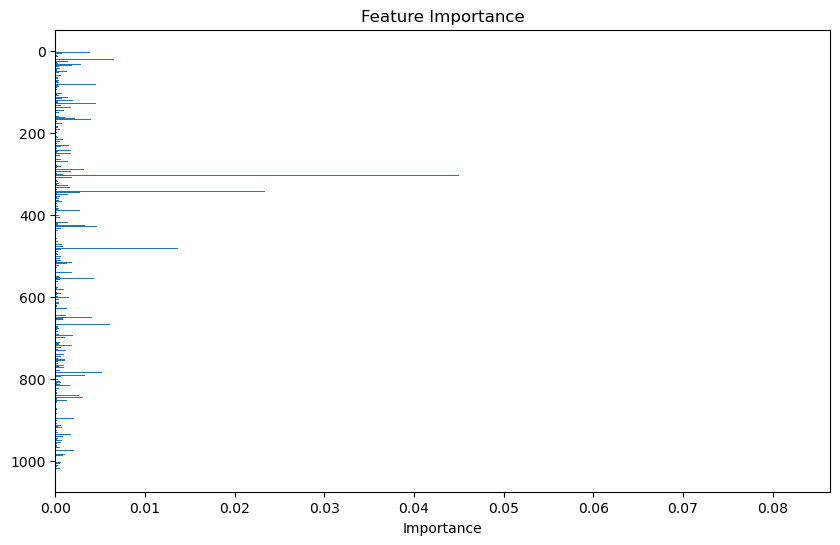

In [11]:
for importances in importances_list:
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.ylim(plt.ylim()[::-1])
    plt.show()